# Teste Tecnico Parte 1 - Algoritmos aplicados à base de dados de Fraudes do Kaggle

#### **Descrição da avaliação**

Essa parte consiste na elaboração de um Jupyter Notebook (ou outra ferramenta que lhe for mais conveniente para apresentação) com pelo menos 2 técnicas à sua escolha para resolver uma ou mais competições de Fraude contidas no Kaggle. O candidato tem a liberdade para escolha da competição que lhe for mais conveniente, bem como de unir todas as bases de dados caso queira.

**Pacotes obrigatórios para se utilizar:**  

* Pandas;
* Scikit-learn;
* Tensorflow (ou PyTorch).

Opcional: incluir a possibilidade de treinamento dos modelos em GPU.

**Objetivo do teste:**  demonstrar assertividade de desenvolvimento de código, expor
claramente solução utilizada podendo descrever o tratamento dos dados, a escolha
dos algoritmos, as métricas de avaliação, possíveis testes estatísticos e os prós e
contras das soluções utilizadas.

## 1 EDA

Neste etapa vamos realizar a análise exploratória dos dados, identificar as variáveis que poderão contribuir para a predição da fraude trazendo mais informação sobre o problema.

Em virtude da quantidade extensiva de features deste banco de dados, vamos fazer a [EDA](EDA.ipynb) (segue link) em outro notebook visando focar este notebook no processo de análise da modelagem dos dados.


In [1]:
import pickle
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import warnings
warnings.filterwarnings("ignore")

from sklearn.calibration import CalibrationDisplay
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

In [2]:
# Carregando os arquivos de treino e teste com a seleção de features
# já realizada na etada do EDA

with open('./ieee-fraud-detection/X.train', 'rb') as Xtrain_file:
    X_train = pickle.load(Xtrain_file)
    
with open('./ieee-fraud-detection/y.train', 'rb') as ytrain_file:
    y_train = pickle.load(ytrain_file)
    
with open('./ieee-fraud-detection/X.test', 'rb') as Xtest_file:
    X_test = pickle.load(Xtest_file)
    

print('Forma dos dados de treino',X_train.shape,'Forma dos dados de teste',X_test.shape)   

Forma dos dados de treino (590540, 60) Forma dos dados de teste (506691, 60)


## 2 Modelagem

Nesta etapa vamos modelar os dados utilizando algoritmos de Machine Learning.

Estas serão as próximas etapas:
* Separação dos dados de treino em conjunto de treino e validação
* Escolha de algoritmos de Machine Learning - Nesta etapa vamos selecionar um conjunto de modelos que vamos testar em uma configuração default de parâmetros. A partir desse primeiro teste vamos selecionar os melhores modelos ou modelo mais promissor para uma etapa de otimização de hiperparâmetros.
    * Treinamento dos algoritmos - Não utilizaremos o validação cruzada para estes testes, uma vez que estamos na fase de seleção de modelos e buscamos otimizar o tempo de treinamento.
    * Avaliação dos algoritmos - Nesta etapa vamos utilizar a métrica de acurácia (roc-auc) para avaliar a performance dos modelos. Essa métrica foi escolhida por mensurar a capacidade de separação dos dados em classes, dessa forma, o modelo mais promissor para a classificação dos dados será o modelo que melhor separa os dados em classes. A metrica escolhida poderia varia 
* Otimização dos modelos ou do modelo final - Utilizaremos a toolbox de otimização de hiperparâmetros optuna para otimizar os parâmetros de nosso modelo.
* Considerações finais - comentários finais sobre o modelo final e a performance do modelo.

In [3]:
# Dividindo os dados de treino em treino e validação
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=0.2,
                                                  random_state=42,
                                                  stratify=y_train)


### 2.0 Regressão logística - Logistic Regression (Base-line)

Este modelo será utilizado como base-line para comparar os resultados dos modelos de Machine Learning.

Este modelo é bem interpretável, pois ele é um modelo de regressão logística, que é uma forma de classificação que utiliza a probabilidade de uma classe para determinar se um dado é fraude ou não.

**Prós:**
* Simples de implementar.
* Esse modelo não faz suposições sobre distribuições de classes.
* Predição muito rápida.
* Os coeficientes do modelo podem ser interpretados como indicadores de importância das variáveis.

**Contras:**
* Problemas não lineares não podem ser resolvidos com regressão logística porque tem uma superfície de decisão linear. Dados linearmente separáveis raramente são encontrados em cenários do mundo real.
* A Regressão Logística precisa que as variáveis independentes estejam linearmente relacionadas às probabilidades logarítmicas (log(p/(1-p)).
* Não é muito poderoso e pode ser fácilmente superado por outros algoritmos.

### 2.1 Naive Bayes

Como o Naive Bayes é super rápido, pode ser usado para fazer previsões em tempo real para classificação multiclasse, e também é muito útil para classificação de texto.

**Prós**: 
* Otimização de hiperparâmetros, poucos parametros devem ser testados e processamento rápido.
* Insensível à variáveis irrelevantes.
* Treinamento e processamento de dados rápido, pode ser utilizado em aplicações online.
* Tem bom desempenho para altas dimensionalidades de dados

**Contras**:
* Precisa de uma grande quantidade de dados para atingir um bom resultado.
* Não costuma ser um bom estimador. Apresenta uma performance inferior a outros classificadores dependendo do tipo de problema. Não se deve muito a sério as probabilidades da predict_proba.
* Os dados DEVEM representar muito bem a população.


### 2.1 Random Forest

Modelo de classificação que utiliza arvores de decisão para classificar dados. Este é o modelo base para outros modelos de classificação, como o Isolation Forest, XGBoost e o LightGBM.

**Prós:**
* Este modelo funciona bem com dados categóricos e numéricos. Normalmente, nenhuma escala ou transformação de variáveis é necessária.
* Este modelo executa implicitamente a seleção de variáveis e geram árvores de decisão não correlacionadas.
* É um ótimo modelo quando você precisa trabalhar com um grande número de variáveis nos dados.
* Este modelo é bem tolerante a dados outliers.
* Lida bem com relacionamentos lineares e não lineares.
* Este modelo geralmente fornecem alta precisão e equilibram bem entre viés e variância.
* Não sofre de overfiting porque decompõem o conjunto de dados em subconjuntos de dados.

**Contras:**
* Este modelo não é facilmente interpretável.
* Este modelo pode ser computacionalmente intensivo para grandes conjuntos de dados.
* É um modelo do tipo caixa preta, é dificil extrair uma interpretação dos dados.
* As variáveis tem que ter um bom potencial informativo para que o modelo desempenhe bem.



### 2.2 Isolation Forest

Isolation Forest é um modelo de detecção de outliers que utiliza uma árvore de decisão para detectar anomalias e um algoritmo não supervisonado.

**Prós:**
* Computacionalmente rápido
* Eficiente com alta dimensionalidade de dados
* Pode ser utilizado em conjunto com outros modelos de Machine Learning
* A otimização é muito simples, um parametro parametro float.

**Contras:**
* Depende do número de dados
* Não é um modelo de classificação, ele é um modelo de detecção de outliers através de segregação de dados utlizando arvores para particionar o espação das variáveis de entrada.
* Não tem a curva de probabilidade 

Para maiores informações segue link da [biblioteca do scikitlearn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html) e do [artigo orginal](icdm08b.pdf).

### 2.3 XGBoost

O XGBoost é uma implementação do modelo de árvores de decisão impulsionadas por gradiente e projetadas para velocidade e desempenho.

**Prós:**
* Menos engenharia de recursos necessária (não há necessidade de dimensionamento, normalização de dados, também pode lidar bem com valores ausentes)
* A importância do recurso pode ser encontrada (importância de saída de cada recurso, pode ser usada para seleção de recursos)
* Outliers têm impacto mínimo **obs.**. 
* Lida bem com conjuntos de dados de grande porte.
* Boa velocidade de execução
* Bom desempenho do modelo (vence a maioria das competições Kaggle como fez para esse conjunto de dados)
* Menos propenso a overfitting

**Contras:**
* Interpretação difícil, visualização difícil
* Overfitting possível se os parâmetros não forem ajustados corretamente.
* Mais difícil de ajustar, pois há muitos hiperparâmetros.
* O XGBoost não funciona tão bem em dados esparsos e não estruturados.

**Observação:** a sensibilidade em relação aos outliers divide opniões em relação a esse algoritmo.

### 2.4 MLP Multi Layer Perceptron - Classification


**Prós:**
* As redes neurais são flexíveis e podem ser usadas para problemas de regressão e classificação. Quaisquer dados que possam ser tornados numéricos podem ser usados no modelo, pois a rede neural é um modelo matemático com funções de aproximação.
* As redes neurais são boas para modelar com dados não lineares com grande número de entradas; por exemplo, imagens. É confiável em uma abordagem de tarefas envolvendo muitos recursos. Ele funciona dividindo o problema de classificação em uma rede em camadas de elementos mais simples.
* Uma vez treinado, as previsões são bem rápidas.
* As redes neurais podem ser treinadas com qualquer número de entradas e camadas.
* As redes neurais funcionam melhor com mais pontos de dados.

**Contras:**

* As redes neurais são caixas pretas, o que significa que não podemos saber o quanto cada variável independente está influenciando as variáveis dependentes.
* É computacionalmente muito caro e demorado treinar com CPUs tradicionais.
* As redes neurais dependem muito dos dados de treinamento. Isso leva ao problema de over-fitting e generalização. O modo depende mais dos dados de treinamento e pode ser ajustado aos dados.


# 3 Treinamento dos modelos

In [4]:
# Criando um dataframe com para armazezar os resultados
df_results = pd.DataFrame()

## 3.1 Criação dos modelos de Machine Learning

In [5]:
# Gerando os Classificadores
lr = LogisticRegression()
gnb = GaussianNB()
rfc = RandomForestClassifier()
xgb = XGBClassifier(missing=-1, #missing=-1 indicar que os valores faltantes serão tratados como -1
                    eval_metric='auc') 
iso_fc = IsolationForest()

# Criando uma lista com os classificadores
clf_list = [
    (lr, "Logistic"),
    (gnb, "Naive Bayes"),
    (rfc, "Random forest"),
    (xgb, "XGBoost"),
    (iso_fc, "Isolation Forest")  
]

## 3.2 Treinamento dos modelos padrão com o conjunto de dados de treino

Modelo Logistic AUC: 0.5461383181192874
Modelo Naive Bayes AUC: 0.6692077595216774
Modelo Random forest AUC: 0.6676953874164403
Modelo XGBoost AUC: 0.613777900385764
Modelo Isolation Forest AUC: 0.6161113581020453


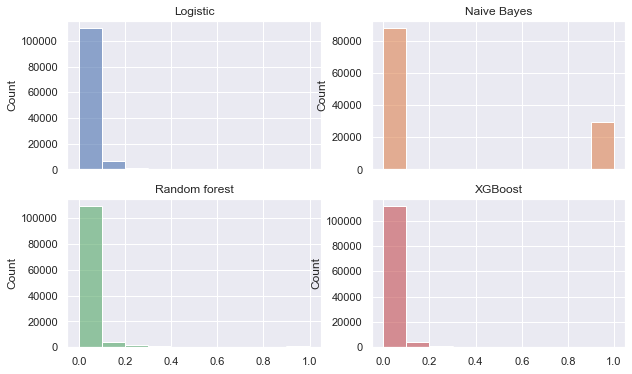

In [6]:
# Treinando os classificadores
row_g = len(clf_list)//2
fig, axes = plt.subplots(row_g, 2, sharex=True, figsize=(10, row_g*3))
axes = axes.ravel()
bins = np.arange(0, 1.1, 0.1)
list_auc = []
nome_clf = []
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    # Gerando metrica de performance
    predictions = clf.predict(X_val)
    if name != 'Isolation Forest': # Isolation Forest não tem metrica predict_proba
        axes[i].set_title('{}'.format(name))
        sns.histplot(clf.predict_proba(X_val)[:, 1],
                 bins=bins,
                 alpha = 0.6,
                 color=sns.color_palette()[i],
                 ax=axes[i])
    else:
        # Ajuste das predições para equivaler ao formato do problema
        predictions = np.where(predictions == 1, 0, 1)
        # Avaliação do modelo
    print(f'Modelo {name} AUC: {roc_auc_score(y_val, predictions)}')
    list_auc.append(roc_auc_score(y_val, predictions))
    nome_clf.append(name)
df_results['base_original'] = list_auc
df_results['nome_clf'] = nome_clf
df_results.set_index('nome_clf', inplace=True)


## 3.3 Treinamento dos modelos com o variações do conjunto de dados de treino



Nosso problema de classificação é classificar se um dado é fraude ou não. Porém no nosso EDA identificamos que 96,5% das transações não são fraudes e 3,5% são fraudes. Isso pode levar nosso modelo ao viés de não classificar os dados como fraudes. 

Para evitar esse viés, vamos aplicar 4 técnicas pra lidar com desbalanceamento de dados sendo eles: **Undersampling**, **Oversampling**, **SMOTE** e **ADASYN**.

O objetivo é equilibrar os dados de treino para o modelo consiga aprender a indetificar melhor as fraudes em relação as transações não fraudulentas.

**Observação:** ainda estaremos trabalhando com os modelos em sua configuração padrão. Os hiperparâmetros serão otimizados em um processo posterior.

In [7]:
resampler_list = ['RandomUnderSampler', 'RandomOverSampler', 'SMOTE', 'ADASYN']

In [8]:
# Automatizando o processo de resampling para vários metodos para avaliar o melhor
for cod in resampler_list:
    print(cod+'()')
    eval_resampler = eval(cod+'()')
    X_resampled, y_resampled = eval_resampler.fit_resample(X_train, y_train)
    list_auc = []
    for i, (clf, name) in enumerate(clf_list):
        clf.fit(X_resampled, y_resampled)
        # Gerando metrica de performance
        predictions = clf.predict(X_val)
        if name == 'Isolation Forest':
            # Ajuste das predições para equivaler ao formato do problema
            predictions = np.where(predictions == 1, 0, 1)
        list_auc.append(roc_auc_score(y_val, predictions))
    df_results[cod] = list_auc

RandomUnderSampler()
RandomOverSampler()
SMOTE()
ADASYN()


<AxesSubplot:title={'center':'AUC por Resampler'}, xlabel='Modelo', ylabel='AUC'>

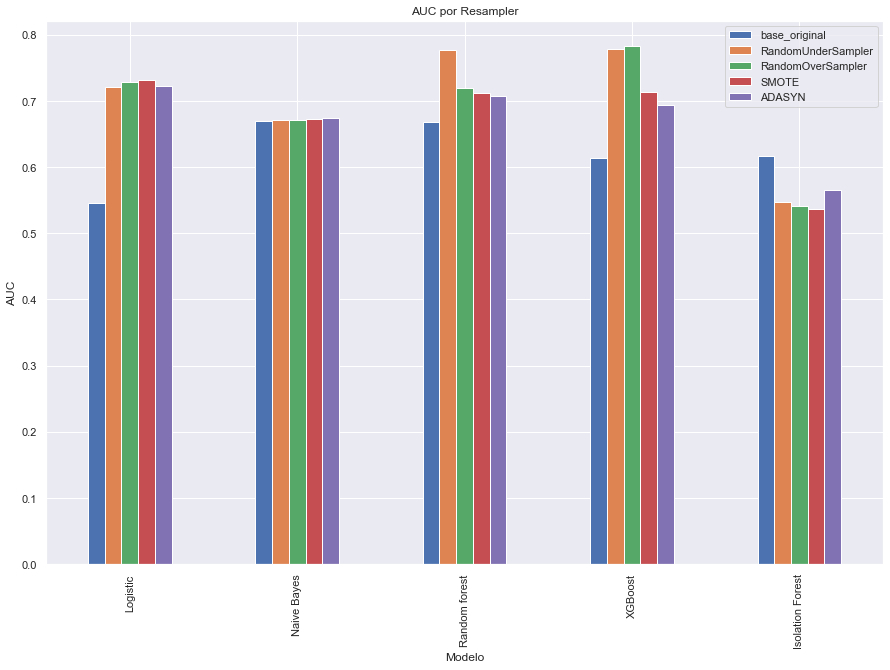

In [9]:
df_results.plot(kind='bar', figsize=(15, 10), ylabel='AUC',xlabel='Modelo', title='AUC por Resampler')

Observamos no gráfico acima que exceto para o modelo de Isolation Forest houve uma redução de desempenho do modelo quando balanceamos os dados. Isso é esperado porque esse modelo trabalha buscando traçar uma superficie de separação dos dados no espaço das variáveis e ao equalizar as classes de fraude e não fraude o desempenho do modelo vai cair.

O modelo Naive Bayes não apresentou nenhuma alteração no desempenho quando balanceamos os dados. **melhorara explicação**.

Os demais modelo apresentaram uma melhor performance quando balanceamos os dados. Especialmente o modelo Random Forest e o XGBoost. Como ambos destes dois últimos apresentaram uma melhora da performance quando aplicamos o RandomUnderSampler e este método reduz o número de dados de treino, economizando assim tempo de treinamento.

Vamos usar o RandomUnderSampler para balancear os dados de treino na etapa de otimização dos hiperparâmetros. 

## 3.4 Rede Neural - MLP (Multi-Layer Perceptron)

Nessa seção iremos trabalhar com um modelo de rede neural MLP para nosso problema de classificação.

As redes neurais são estruturas de modelos que podem ter as arquiteturas de estruturas mais diversas e complexas. Achar a estrutura de uma rede neural é uma tarefa complexa e difícil. 

Em virtude de nossa limitação de tempo, vamos utilizar apenas a estrutura de uma rede neural MLP.

**Pros:**
* Este modelo é um aproximador geral de funções, lineares e não lineares. Assim ele pode se moldar a qualquer função. Neste caso, como queremos determinar uma fronteira de seperação as redes podem se aproximar de fronteiras fortemente não lineares.


**Contras:**


In [11]:
# Carregando o tensor flow para o modelo de classificação
import tensorflow as tf
tf.__version__

'2.3.0'

In [12]:
# Criando as camdas da rede neural MLP simples
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

rede_simples = Sequential()

# Camada de input e primeira oculta
rede_simples.add(Dense(10, input_dim=X_train.shape[1], activation='relu'))

# Camada oculta 1
rede_simples.add(Dense(4, activation='relu'))

# Camada output
rede_simples.add(Dense(1,activation='sigmoid'))

# Printando a rede
#print(rede_simples.summary())

In [13]:
# Compilação da rede
rede_simples.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC'])
# Obtendo os pesos iniciais caso precise reiniciar o treinamento
pesos_iniciais = rede_simples.get_weights() 

In [14]:
# Normalizando os dados de treino
resampler = RandomUnderSampler()
X_train_res, y_train_res = resampler.fit_resample(X_train, y_train)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_val_scaled = scaler.transform(X_val)

In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# Utilizamos o early stopping para parar o treinamento caso o modelo não melhore 
# em um determinado número de épocas (epochs) para evitar que o modelo 
# sofra overfitting
early_stop = EarlyStopping(monitor = 'val_loss', 
                           min_delta = 0.001,
                           patience = 10, 
                           verbose = 1, mode = 'auto')

melhor_modelo = ModelCheckpoint('best_model.h5',
                                monitor='val_loss',
                                save_best_only=True)

In [16]:
# setamos os pesos iniciais iguais à versão antes do treinamento 
# pra ter um comparativo mais real.
rede_simples.set_weights(pesos_iniciais)

In [17]:
historico = rede_simples.fit(X_train_scaled,
                             y_train_res,
                             epochs=100,
                             verbose=1,
                             validation_data=(X_val_scaled, y_val),
                             callbacks=[early_stop, melhor_modelo])

Epoch 1/100
1034/1034 [==============================] - 3s 3ms/step - loss: 0.5845 - auc: 0.7540 - val_loss: 0.5074 - val_auc: 0.7991
Epoch 2/100
1034/1034 [==============================] - 3s 3ms/step - loss: 0.5383 - auc: 0.7992 - val_loss: 0.5270 - val_auc: 0.8080
Epoch 3/100
1034/1034 [==============================] - 3s 2ms/step - loss: 0.5288 - auc: 0.8061 - val_loss: 0.5128 - val_auc: 0.8111
Epoch 4/100
1034/1034 [==============================] - 3s 3ms/step - loss: 0.5236 - auc: 0.8106 - val_loss: 0.5303 - val_auc: 0.8106
Epoch 5/100
1034/1034 [==============================] - 2s 2ms/step - loss: 0.5205 - auc: 0.8132 - val_loss: 0.4554 - val_auc: 0.8163
Epoch 6/100
1034/1034 [==============================] - 3s 2ms/step - loss: 0.5186 - auc: 0.8144 - val_loss: 0.4671 - val_auc: 0.8148
Epoch 7/100
1034/1034 [==============================] - 2s 2ms/step - loss: 0.5168 - auc: 0.8157 - val_loss: 0.5504 - val_auc: 0.8161
Epoch 8/100
1034/1034 [==============================] 

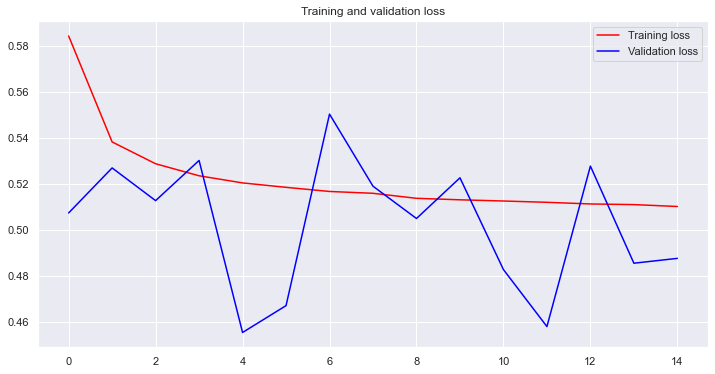

In [18]:
# valor da função de perda NOS DADOS DE TREINO a cada epoch
loss = historico.history['loss']

# valor da função de perda NOS DADOS DE VALIDAÇÃO a cada epoch
val_loss = historico.history['val_loss']

# numero de epochs
epochs = range(len(loss))

# plot
plt.figure(figsize=(12, 6))
plt.plot(epochs, loss, 'red', label = 'Training loss')
plt.plot(epochs, val_loss, 'blue', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

A curva acima indica que tanto no treinamento quando na validação o modelo obteve um comportamento similar em relação a função de perda. Isso indica que o modelo no sofreu overfitting. 

Quando utilizamos o conjunto de dados sem o RandomUnderSampler, o modelo demorou mais para convergir e o resultado em termos da metrica AUC ficou inferior.

**Observação:** cuidado ao observar o gráfico, pois as escalas de y estão bem achatadas e podem levar a uma intrepretação equivocada do gráfico.

# 4 Otimização dos hiperparâmetros

Vamos realizar a otimização dos hiperparâmetros dos modelos de Machine Learning do tipo rasos devido ao menor esforço computacional de treinamento para esses modelos.

Utilizaremos o pacote optuna que apresenta um bom desepenho para otimização de hiperparâmetros devido ao utlizar combinações de tecnicas de otimização como: RandomizedSearchCV, GridSearchCV, GeneticSearch e BayesianOptimization.

In [19]:
# Instalação do optuna
#!pip install optuna

In [20]:
import optuna

In [21]:
def objective(trial):
    resampler = RandomUnderSampler()
    X_train_resampled, y_train_resampled = resampler.fit_resample(X_train,y_train)
    classifier_name = trial.suggest_categorical("classifier", ["NaiveBayes",
                                                               "RandomForest",
                                                               "IsolationForest",
                                                               "LogisticRegression"])
    
    if classifier_name == "IsolationForest":
        contamination = trial.suggest_float("contamination", 0.0, 0.5,step=0.01)
        n_estimators = trial.suggest_int("n_estimators", 100, 2000, step=200)
        max_sample_rate = trial.suggest_uniform("max_sample_rate", 0.5, 1.0)
        classifier_obj = IsolationForest(n_estimators=n_estimators, 
                                        contamination=contamination,
                                        bootstrap=True)                                   
        
    elif classifier_name == "NaiveBayes":
        vrs_c = trial.suggest_float("vrs_c", 0.01, 1, step=0.01)
        classifier_obj = GaussianNB(var_smoothing = vrs_c)
        
    elif classifier_name == "RandomForest":
        rf_max_depth = trial.suggest_int("rf_max_depth", 2, 13, log=True)
        rf_n_estimators = trial.suggest_int("rf_n_estimators", 100, 5000, step=200)
        rf_min_impurity_decrease = trial.suggest_discrete_uniform("rf_min_impurity_decrease", 0.1, 1.0,0.1)
        classifier_obj = RandomForestClassifier(max_depth=rf_max_depth,
                                                min_impurity_decrease=rf_min_impurity_decrease,
                                                n_estimators=rf_n_estimators)
        
    elif classifier_name == "LogisticRegression":
        lr_C = trial.suggest_float("lr_C", 0.01, 10, log=True)
        classifier_obj = LogisticRegression(C=lr_C)        
            
    classifier_obj.fit(X_train_resampled, y_train_resampled)
    predictions = classifier_obj.predict(X_val)
    
    return roc_auc_score(y_val, predictions)

In [22]:
# Estudo de otimização com o optuna
# Modelos de classificação do sklearn
#sampler = optuna.samplers.CmaEsSampler()
study_skl = optuna.create_study(direction="maximize")#, sampler=sampler)
study_skl.optimize(objective,n_jobs=-1,n_trials=50)
print(study_skl.best_trial)

[I 2022-04-06 10:34:56,309] A new study created in memory with name: no-name-1a9955ec-4a58-479b-bb74-a301f27f96be
[I 2022-04-06 10:35:01,561] Trial 3 finished with value: 0.6418540715761152 and parameters: {'classifier': 'NaiveBayes', 'vrs_c': 0.6}. Best is trial 3 with value: 0.6418540715761152.
[I 2022-04-06 10:35:02,150] Trial 2 finished with value: 0.6359550378729358 and parameters: {'classifier': 'NaiveBayes', 'vrs_c': 0.88}. Best is trial 3 with value: 0.6418540715761152.
[I 2022-04-06 10:35:02,243] Trial 9 finished with value: 0.6361067238598248 and parameters: {'classifier': 'NaiveBayes', 'vrs_c': 0.92}. Best is trial 3 with value: 0.6418540715761152.
[I 2022-04-06 10:35:03,546] Trial 17 finished with value: 0.6425046847932478 and parameters: {'classifier': 'NaiveBayes', 'vrs_c': 0.17}. Best is trial 17 with value: 0.6425046847932478.
[I 2022-04-06 10:35:05,926] Trial 6 finished with value: 0.7322508591949825 and parameters: {'classifier': 'LogisticRegression', 'lr_C': 0.146478

FrozenTrial(number=46, values=[0.7323456807158896], datetime_start=datetime.datetime(2022, 4, 6, 10, 39, 32, 947889), datetime_complete=datetime.datetime(2022, 4, 6, 10, 39, 38, 104051), params={'classifier': 'LogisticRegression', 'lr_C': 0.7781751264581169}, distributions={'classifier': CategoricalDistribution(choices=('NaiveBayes', 'RandomForest', 'IsolationForest', 'LogisticRegression')), 'lr_C': LogUniformDistribution(high=10.0, low=0.01)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=46, state=TrialState.COMPLETE, value=None)


In [23]:
fig = optuna.visualization.plot_optimization_history(study_skl)
fig.show()

In [27]:
study_skl.best_trial

FrozenTrial(number=46, values=[0.7323456807158896], datetime_start=datetime.datetime(2022, 4, 6, 10, 39, 32, 947889), datetime_complete=datetime.datetime(2022, 4, 6, 10, 39, 38, 104051), params={'classifier': 'LogisticRegression', 'lr_C': 0.7781751264581169}, distributions={'classifier': CategoricalDistribution(choices=('NaiveBayes', 'RandomForest', 'IsolationForest', 'LogisticRegression')), 'lr_C': LogUniformDistribution(high=10.0, low=0.01)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=46, state=TrialState.COMPLETE, value=None)

Fizemos um estudo pouco aprofundado de otimização de hiperparâmetros para os modelos do sci-kit learn, e nesse estudo que ofereceu o melhor desempenho foi o modelo de Regressão Logistica com um AUC de validação de ~0.78. 

### 3.1 Otimização dos hiperparâmetros do XGBoost

In [28]:
import xgboost as xgb

In [29]:
def objective(trial):
    resampler = RandomUnderSampler()
    X_train_resampled, y_train_resampled = resampler.fit_resample(X_train,y_train)
    dtrain = xgb.DMatrix(X_train_resampled, label=y_train_resampled)
    dvalid = xgb.DMatrix(X_val, label=y_val)    

    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "missing": -1,
        "tree_method": "hist",
        "early_stopping_rounds": 50,
        "n_estimators": trial.suggest_int("n_estimators", 100, 5000, step=200),
        "subsample": trial.suggest_uniform("subsample", 0.1, 1),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.1, 1),
        "eta": trial.suggest_uniform("eta", 0.01, 0.2),
        "max_depth": trial.suggest_int("max_depth", 3, 13),
        }

    # Add a callback for pruning.
    bst = xgb.train(param, dtrain, evals=[(dvalid, "validation")])
    predictions = bst.predict(dvalid)
    
    return roc_auc_score(y_val, predictions)

In [30]:
# Estudo de otimização com o optuna
# Modelos de classificação do sklearn
#sampler = optuna.samplers.CmaEsSampler()
study_xgb = optuna.create_study(direction="maximize")#, sampler=sampler)
study_xgb.optimize(objective,n_jobs=-1,n_trials=50)
print(study_xgb.best_trial)

[I 2022-04-06 10:48:06,289] A new study created in memory with name: no-name-31fcd3bd-f936-4e86-844a-9d69efbfed37


[0]	validation-auc:0.74949
[0]	validation-auc:0.76379[0]	validation-auc:0.80162

[0]	validation-auc:0.79048[0]	validation-auc:0.70454
[0]	validation-auc:0.80654[0]	validation-auc:0.78838

[0]	validation-auc:0.82327

[0]	validation-auc:0.73124
[1]	validation-auc:0.78886
[1]	validation-auc:0.78246[0]	validation-auc:0.72009[0]	validation-auc:0.76830
[0]	validation-auc:0.82046


[1]	validation-auc:0.81959[0]	validation-auc:0.78774

[0]	validation-auc:0.74296[0]	validation-auc:0.82687

[1]	validation-auc:0.81182
[1]	validation-auc:0.78525
[2]	validation-auc:0.79090[1]	validation-auc:0.81172

[1]	validation-auc:0.72616
[0]	validation-auc:0.82549[1]	validation-auc:0.81418[1]	validation-auc:0.82906


[2]	validation-auc:0.78204
[2]	validation-auc:0.75945[2]	validation-auc:0.81124

[2]	validation-auc:0.82258
[1]	validation-auc:0.83039
[3]	validation-auc:0.79229
[1]	validation-auc:0.81205
[2]	validation-auc:0.81568
[1]	validation-auc:0.73317
[2]	validation-auc:0.79074
[1]	validation-auc:0.79746
[

[I 2022-04-06 10:48:09,899] Trial 0 finished with value: 0.7959950742866585 and parameters: {'n_estimators': 4700, 'subsample': 0.6540676560209686, 'colsample_bytree': 0.47665028384828156, 'eta': 0.04730343914329829, 'max_depth': 3}. Best is trial 0 with value: 0.7959950742866585.


[7]	validation-auc:0.81660
[4]	validation-auc:0.76914
[9]	validation-auc:0.81635[7]	validation-auc:0.82314

[6]	validation-auc:0.81064


[I 2022-04-06 10:48:09,953] Trial 3 finished with value: 0.7897234075988516 and parameters: {'n_estimators': 700, 'subsample': 0.29096885932556527, 'colsample_bytree': 0.19042978343345163, 'eta': 0.1479845675834264, 'max_depth': 3}. Best is trial 0 with value: 0.7959950742866585.


[5]	validation-auc:0.83740
[7]	validation-auc:0.82892[4]	validation-auc:0.84677

[4]	validation-auc:0.80620


[I 2022-04-06 10:48:10,025] Trial 8 finished with value: 0.8163505926305252 and parameters: {'n_estimators': 3900, 'subsample': 0.1742959261637349, 'colsample_bytree': 0.3191304707029924, 'eta': 0.11911315346616992, 'max_depth': 5}. Best is trial 8 with value: 0.8163505926305252.


[6]	validation-auc:0.82221
[8]	validation-auc:0.81917
[6]	validation-auc:0.83747
[4]	validation-auc:0.84365
[5]	validation-auc:0.82517
[7]	validation-auc:0.82463[8]	validation-auc:0.82672[5]	validation-auc:0.81811
[8]	validation-auc:0.83120
[5]	validation-auc:0.80630


[7]	validation-auc:0.81546[6]	validation-auc:0.82662[5]	validation-auc:0.84393[9]	validation-auc:0.81965[6]	validation-auc:0.83758



[7]	validation-auc:0.83752

[5]	validation-auc:0.77653
[5]	validation-auc:0.84828
[9]	validation-auc:0.82762[6]	validation-auc:0.81012[8]	validation-auc:0.82640
[6]	validation-auc:0.81793


[9]	validation-auc:0.83280
[6]	validation-auc:0.84374
[8]	validation-auc:0.81617
[7]	validation-auc:0.83796
[7]	validation-auc:0.82847
[6]	validation-auc:0.78303[8]	validation-auc:0.83989

[9]	validation-auc:0.82794
[7]	validation-auc:0.82239
[6]	validation-auc:0.84866
[8]	validation-auc:0.83869
[7]	validation-auc:0.84425
[7]	validation-auc:0.81439
[9]	validation-auc:0.81997


[I 2022-04-06 10:48:10,551] Trial 9 finished with value: 0.8196489152864025 and parameters: {'n_estimators': 3900, 'subsample': 0.9124743147533568, 'colsample_bytree': 0.6319572022348711, 'eta': 0.022721930720137916, 'max_depth': 6}. Best is trial 9 with value: 0.8196489152864025.
[I 2022-04-06 10:48:10,573] Trial 4 finished with value: 0.8327995371277263 and parameters: {'n_estimators': 4900, 'subsample': 0.6510471611695634, 'colsample_bytree': 0.5345995969035003, 'eta': 0.15221189997589, 'max_depth': 7}. Best is trial 4 with value: 0.8327995371277263.


[8]	validation-auc:0.82859
[7]	validation-auc:0.79415[8]	validation-auc:0.82352



[I 2022-04-06 10:48:10,667] Trial 11 finished with value: 0.8276197790009917 and parameters: {'n_estimators': 3700, 'subsample': 0.6680833773788901, 'colsample_bytree': 0.9633906351722257, 'eta': 0.12593942847147516, 'max_depth': 6}. Best is trial 4 with value: 0.8327995371277263.


[7]	validation-auc:0.84942[8]	validation-auc:0.84434

[9]	validation-auc:0.84216
[9]	validation-auc:0.83957
[8]	validation-auc:0.81579


[I 2022-04-06 10:48:10,727] Trial 13 finished with value: 0.8279406689623113 and parameters: {'n_estimators': 4700, 'subsample': 0.13831380776028557, 'colsample_bytree': 0.5355885525848981, 'eta': 0.020733133863372326, 'max_depth': 9}. Best is trial 4 with value: 0.8327995371277263.
[I 2022-04-06 10:48:10,845] Trial 14 finished with value: 0.819970684119128 and parameters: {'n_estimators': 3500, 'subsample': 0.1679308201802596, 'colsample_bytree': 0.28027583538681333, 'eta': 0.14647136860072846, 'max_depth': 8}. Best is trial 4 with value: 0.8327995371277263.


[9]	validation-auc:0.82649[8]	validation-auc:0.79511[8]	validation-auc:0.84984
[9]	validation-auc:0.84649

[9]	validation-auc:0.81505
[9]	validation-auc:0.83042

[9]	validation-auc:0.79519
[9]	validation-auc:0.85079[0]	validation-auc:0.72431
[0]	validation-auc:0.71078

[1]	validation-auc:0.72925
[1]	validation-auc:0.76676


[I 2022-04-06 10:48:11,418] Trial 5 finished with value: 0.8421685016203131 and parameters: {'n_estimators': 1700, 'subsample': 0.9069453677937501, 'colsample_bytree': 0.8532378391529852, 'eta': 0.13230889735361848, 'max_depth': 9}. Best is trial 5 with value: 0.8421685016203131.


[0]	validation-auc:0.79612
[2]	validation-auc:0.76397
[2]	validation-auc:0.77236
[1]	validation-auc:0.80280
[3]	validation-auc:0.77133
[3]	validation-auc:0.77198


[I 2022-04-06 10:48:11,565] Trial 6 finished with value: 0.8395749372410984 and parameters: {'n_estimators': 1700, 'subsample': 0.7419682649533909, 'colsample_bytree': 0.9901886154140521, 'eta': 0.07777710867369447, 'max_depth': 9}. Best is trial 5 with value: 0.8421685016203131.


[2]	validation-auc:0.80671
[4]	validation-auc:0.77296
[4]	validation-auc:0.78663
[5]	validation-auc:0.77421


[I 2022-04-06 10:48:11,711] Trial 1 finished with value: 0.8150590794235983 and parameters: {'n_estimators': 4900, 'subsample': 0.9296588021652322, 'colsample_bytree': 0.21337492705247033, 'eta': 0.030518353113790142, 'max_depth': 13}. Best is trial 5 with value: 0.8421685016203131.
[I 2022-04-06 10:48:11,712] Trial 15 finished with value: 0.846488237372977 and parameters: {'n_estimators': 500, 'subsample': 0.9913635684085524, 'colsample_bytree': 0.6541231819001835, 'eta': 0.03970205084026225, 'max_depth': 12}. Best is trial 15 with value: 0.846488237372977.


[3]	validation-auc:0.81382


[I 2022-04-06 10:48:11,714] Trial 2 finished with value: 0.8304123663575456 and parameters: {'n_estimators': 4700, 'subsample': 0.12022457913771378, 'colsample_bytree': 0.7171961577258764, 'eta': 0.17722491831427342, 'max_depth': 10}. Best is trial 15 with value: 0.846488237372977.
[I 2022-04-06 10:48:11,725] Trial 12 finished with value: 0.8264936899845864 and parameters: {'n_estimators': 4300, 'subsample': 0.1838218799629379, 'colsample_bytree': 0.38549386958646714, 'eta': 0.06951895305967006, 'max_depth': 11}. Best is trial 15 with value: 0.846488237372977.


[6]	validation-auc:0.77733[5]	validation-auc:0.78553

[4]	validation-auc:0.81567
[7]	validation-auc:0.79242


[I 2022-04-06 10:48:11,894] Trial 10 finished with value: 0.8508024578891366 and parameters: {'n_estimators': 4700, 'subsample': 0.6745199459686476, 'colsample_bytree': 0.9860616256753023, 'eta': 0.12150681746445807, 'max_depth': 13}. Best is trial 10 with value: 0.8508024578891366.
[I 2022-04-06 10:48:11,903] Trial 7 finished with value: 0.7951902361207974 and parameters: {'n_estimators': 300, 'subsample': 0.7280960977295752, 'colsample_bytree': 0.12360978722716964, 'eta': 0.12181555566573128, 'max_depth': 13}. Best is trial 10 with value: 0.8508024578891366.


[6]	validation-auc:0.78585
[8]	validation-auc:0.79422
[5]	validation-auc:0.81584
[7]	validation-auc:0.79227
[9]	validation-auc:0.79449
[6]	validation-auc:0.81727[8]	validation-auc:0.79595

[9]	validation-auc:0.79712
[7]	validation-auc:0.82196
[8]	validation-auc:0.82296
[9]	validation-auc:0.82345


[I 2022-04-06 10:48:12,890] Trial 18 finished with value: 0.7944951475524785 and parameters: {'n_estimators': 2300, 'subsample': 0.16149734017555364, 'colsample_bytree': 0.1831644635724498, 'eta': 0.1276319325547902, 'max_depth': 5}. Best is trial 10 with value: 0.8508024578891366.


[0]	validation-auc:0.81579
[1]	validation-auc:0.83222


[I 2022-04-06 10:48:13,059] Trial 16 finished with value: 0.7971172051974205 and parameters: {'n_estimators': 2700, 'subsample': 0.5884710586877583, 'colsample_bytree': 0.40393055975127035, 'eta': 0.13916836659996124, 'max_depth': 3}. Best is trial 10 with value: 0.8508024578891366.
[I 2022-04-06 10:48:13,114] Trial 17 finished with value: 0.8234536621154467 and parameters: {'n_estimators': 2700, 'subsample': 0.17522131964134896, 'colsample_bytree': 0.9691050310574602, 'eta': 0.15048877963219573, 'max_depth': 5}. Best is trial 10 with value: 0.8508024578891366.


[2]	validation-auc:0.83735
[0]	validation-auc:0.81672
[3]	validation-auc:0.84191[1]	validation-auc:0.83132

[0]	validation-auc:0.81610
[0]	validation-auc:0.80961
[4]	validation-auc:0.84251[1]	validation-auc:0.83435

[2]	validation-auc:0.83597
[3]	validation-auc:0.83872
[5]	validation-auc:0.84308
[1]	validation-auc:0.82573
[2]	validation-auc:0.83740
[0]	validation-auc:0.81337
[0]	validation-auc:0.81437
[6]	validation-auc:0.84357
[4]	validation-auc:0.84004
[2]	validation-auc:0.83193
[3]	validation-auc:0.83965
[0]	validation-auc:0.81544
[0]	validation-auc:0.81238
[0]	validation-auc:0.81507
[0]	validation-auc:0.81285
[0]	validation-auc:0.81576
[7]	validation-auc:0.84299
[5]	validation-auc:0.84071
[1]	validation-auc:0.83051
[1]	validation-auc:0.83320
[0]	validation-auc:0.81000
[1]	validation-auc:0.83132
[3]	validation-auc:0.83422
[1]	validation-auc:0.83125
[4]	validation-auc:0.84033
[1]	validation-auc:0.83160
[1]	validation-auc:0.82937
[0]	validation-auc:0.80556
[0]	validation-auc:0.81384
[

[I 2022-04-06 10:48:15,120] Trial 19 finished with value: 0.846661635092486 and parameters: {'n_estimators': 2500, 'subsample': 0.4794357049656701, 'colsample_bytree': 0.7577623517224201, 'eta': 0.08819805690646647, 'max_depth': 12}. Best is trial 10 with value: 0.8508024578891366.


[2]	validation-auc:0.83704
[8]	validation-auc:0.84269
[4]	validation-auc:0.83883
[4]	validation-auc:0.83920
[3]	validation-auc:0.83492
[6]	validation-auc:0.83828
[4]	validation-auc:0.83994
[7]	validation-auc:0.84161
[4]	validation-auc:0.84023
[4]	validation-auc:0.83558
[3]	validation-auc:0.83241
[4]	validation-auc:0.83862
[3]	validation-auc:0.83726
[3]	validation-auc:0.83658
[4]	validation-auc:0.83239[5]	validation-auc:0.84002

[4]	validation-auc:0.83912
[3]	validation-auc:0.84016
[5]	validation-auc:0.83969
[7]	validation-auc:0.83858
[5]	validation-auc:0.83648
[9]	validation-auc:0.84463
[5]	validation-auc:0.83964[4]	validation-auc:0.83962

[4]	validation-auc:0.83581
[5]	validation-auc:0.84223[8]	validation-auc:0.84338

[5]	validation-auc:0.84047


[I 2022-04-06 10:48:15,503] Trial 21 finished with value: 0.8446287046937412 and parameters: {'n_estimators': 2900, 'subsample': 0.45910104021156706, 'colsample_bytree': 0.803265624429283, 'eta': 0.09117754812133694, 'max_depth': 11}. Best is trial 10 with value: 0.8508024578891366.


[6]	validation-auc:0.84005
[5]	validation-auc:0.83703
[4]	validation-auc:0.83868
[8]	validation-auc:0.84115
[6]	validation-auc:0.83805[5]	validation-auc:0.84067

[9]	validation-auc:0.84479
[6]	validation-auc:0.84235
[6]	validation-auc:0.84010
[6]	validation-auc:0.83998
[5]	validation-auc:0.83418
[4]	validation-auc:0.84066
[5]	validation-auc:0.83925
[6]	validation-auc:0.84074
[6]	validation-auc:0.83576[5]	validation-auc:0.83872[7]	validation-auc:0.84137


[6]	validation-auc:0.83750
[7]	validation-auc:0.84021
[9]	validation-auc:0.84385
[7]	validation-auc:0.84267[6]	validation-auc:0.84036

[7]	validation-auc:0.83929


[I 2022-04-06 10:48:15,811] Trial 22 finished with value: 0.84479749682988 and parameters: {'n_estimators': 900, 'subsample': 0.43998938072469945, 'colsample_bytree': 0.7854586620153761, 'eta': 0.09280381799594073, 'max_depth': 12}. Best is trial 10 with value: 0.8508024578891366.


[7]	validation-auc:0.84098[5]	validation-auc:0.84107
[7]	validation-auc:0.84065

[6]	validation-auc:0.84027
[7]	validation-auc:0.83676[7]	validation-auc:0.84065[0]	validation-auc:0.80889[8]	validation-auc:0.84331
[8]	validation-auc:0.84324

[8]	validation-auc:0.84210[6]	validation-auc:0.84246[7]	validation-auc:0.84008




[7]	validation-auc:0.83797
[8]	validation-auc:0.84325


[I 2022-04-06 10:48:16,076] Trial 20 finished with value: 0.8438538585453288 and parameters: {'n_estimators': 900, 'subsample': 0.42747200694170234, 'colsample_bytree': 0.7847842966993672, 'eta': 0.09205884333318262, 'max_depth': 12}. Best is trial 10 with value: 0.8508024578891366.


[8]	validation-auc:0.84295
[6]	validation-auc:0.83986
[8]	validation-auc:0.84462
[1]	validation-auc:0.82836
[8]	validation-auc:0.84078[9]	validation-auc:0.84435[7]	validation-auc:0.83984[9]	validation-auc:0.84440
[8]	validation-auc:0.84321

[8]	validation-auc:0.84201


[9]	validation-auc:0.84728
[9]	validation-auc:0.84507
[8]	validation-auc:0.83947[7]	validation-auc:0.84307

[9]	validation-auc:0.84515
[9]	validation-auc:0.84488
[2]	validation-auc:0.83198
[9]	validation-auc:0.84534


[I 2022-04-06 10:48:16,618] Trial 26 finished with value: 0.8443918562798998 and parameters: {'n_estimators': 900, 'subsample': 0.4424581227588117, 'colsample_bytree': 0.7699956721766378, 'eta': 0.09204440565806055, 'max_depth': 12}. Best is trial 10 with value: 0.8508024578891366.
[I 2022-04-06 10:48:16,620] Trial 30 finished with value: 0.8450871719961426 and parameters: {'n_estimators': 1100, 'subsample': 0.4470849096495488, 'colsample_bytree': 0.8072965213833049, 'eta': 0.09478586134207075, 'max_depth': 12}. Best is trial 10 with value: 0.8508024578891366.
[I 2022-04-06 10:48:16,640] Trial 31 finished with value: 0.8443536943672675 and parameters: {'n_estimators': 1100, 'subsample': 0.36563139866340755, 'colsample_bytree': 0.7790402525813312, 'eta': 0.09496231577074779, 'max_depth': 12}. Best is trial 10 with value: 0.8508024578891366.


[8]	validation-auc:0.84527


[I 2022-04-06 10:48:16,644] Trial 29 finished with value: 0.8448822399884686 and parameters: {'n_estimators': 1100, 'subsample': 0.41936487392897015, 'colsample_bytree': 0.7701874006554428, 'eta': 0.09259702998609941, 'max_depth': 12}. Best is trial 10 with value: 0.8508024578891366.


[9]	validation-auc:0.84358
[9]	validation-auc:0.84116[9]	validation-auc:0.84275

[8]	validation-auc:0.84249


[I 2022-04-06 10:48:16,683] Trial 24 finished with value: 0.8451442848388261 and parameters: {'n_estimators': 1100, 'subsample': 0.4076247923014051, 'colsample_bytree': 0.784510414569852, 'eta': 0.08928897174086813, 'max_depth': 12}. Best is trial 10 with value: 0.8508024578891366.
[I 2022-04-06 10:48:16,696] Trial 27 finished with value: 0.8472850998869726 and parameters: {'n_estimators': 1100, 'subsample': 0.43435933629596646, 'colsample_bytree': 0.7435223098549892, 'eta': 0.091239970951373, 'max_depth': 12}. Best is trial 10 with value: 0.8508024578891366.


[3]	validation-auc:0.83720[0]	validation-auc:0.82124[0]	validation-auc:0.82101
[9]	validation-auc:0.84335
[9]	validation-auc:0.84670


[1]	validation-auc:0.83571[4]	validation-auc:0.83791
[1]	validation-auc:0.83621



[I 2022-04-06 10:48:17,367] Trial 25 finished with value: 0.8453409737120329 and parameters: {'n_estimators': 1100, 'subsample': 0.4326120485475877, 'colsample_bytree': 0.7930647106879568, 'eta': 0.0963372500763036, 'max_depth': 12}. Best is trial 10 with value: 0.8508024578891366.


[2]	validation-auc:0.83867


[I 2022-04-06 10:48:17,444] Trial 32 finished with value: 0.8427573231721079 and parameters: {'n_estimators': 900, 'subsample': 0.3648516223417376, 'colsample_bytree': 0.7936754474131313, 'eta': 0.09389132899001104, 'max_depth': 12}. Best is trial 10 with value: 0.8508024578891366.
[I 2022-04-06 10:48:17,533] Trial 23 finished with value: 0.8411413578149262 and parameters: {'n_estimators': 1100, 'subsample': 0.3461808243109947, 'colsample_bytree': 0.7712758594777018, 'eta': 0.0923670081802993, 'max_depth': 12}. Best is trial 10 with value: 0.8508024578891366.


[5]	validation-auc:0.83879[2]	validation-auc:0.83956

[3]	validation-auc:0.84323


[I 2022-04-06 10:48:17,602] Trial 33 finished with value: 0.8435702240278241 and parameters: {'n_estimators': 1100, 'subsample': 0.4177404725199629, 'colsample_bytree': 0.7438582687109903, 'eta': 0.09079285225183009, 'max_depth': 12}. Best is trial 10 with value: 0.8508024578891366.


[0]	validation-auc:0.81637
[4]	validation-auc:0.84431[6]	validation-auc:0.83976

[3]	validation-auc:0.84410[1]	validation-auc:0.82798

[7]	validation-auc:0.84007


[I 2022-04-06 10:48:17,830] Trial 34 finished with value: 0.8466966137498688 and parameters: {'n_estimators': 900, 'subsample': 0.4105738422469438, 'colsample_bytree': 0.7714151388704195, 'eta': 0.0914003533299088, 'max_depth': 12}. Best is trial 10 with value: 0.8508024578891366.


[5]	validation-auc:0.84409[2]	validation-auc:0.83112[4]	validation-auc:0.84512




[I 2022-04-06 10:48:17,924] Trial 28 finished with value: 0.8433585731119377 and parameters: {'n_estimators': 1100, 'subsample': 0.4234935184941331, 'colsample_bytree': 0.7670475096016592, 'eta': 0.10078398553364068, 'max_depth': 12}. Best is trial 10 with value: 0.8508024578891366.


[8]	validation-auc:0.84115
[5]	validation-auc:0.84531[3]	validation-auc:0.83560[9]	validation-auc:0.84306


[6]	validation-auc:0.84444
[6]	validation-auc:0.84555
[7]	validation-auc:0.84440[4]	validation-auc:0.83680

[8]	validation-auc:0.84461[7]	validation-auc:0.84613

[5]	validation-auc:0.83802
[9]	validation-auc:0.84703
[6]	validation-auc:0.83942[8]	validation-auc:0.84653



[I 2022-04-06 10:48:18,549] Trial 35 finished with value: 0.8430584926601766 and parameters: {'n_estimators': 1300, 'subsample': 0.4606355211342297, 'colsample_bytree': 0.6680407888258728, 'eta': 0.05454866756815149, 'max_depth': 12}. Best is trial 10 with value: 0.8508024578891366.


[7]	validation-auc:0.83867
[9]	validation-auc:0.84900


[I 2022-04-06 10:48:18,766] Trial 36 finished with value: 0.8470334900424028 and parameters: {'n_estimators': 1700, 'subsample': 0.8302264476990389, 'colsample_bytree': 0.670033214137584, 'eta': 0.05493933617750779, 'max_depth': 12}. Best is trial 10 with value: 0.8508024578891366.


[8]	validation-auc:0.84033


[I 2022-04-06 10:48:19,206] Trial 37 finished with value: 0.8489972772500156 and parameters: {'n_estimators': 1900, 'subsample': 0.8354382738268452, 'colsample_bytree': 0.6592674693503946, 'eta': 0.059916769474747236, 'max_depth': 12}. Best is trial 10 with value: 0.8508024578891366.


[9]	validation-auc:0.84213
[0]	validation-auc:0.82263
[0]	validation-auc:0.82009


[I 2022-04-06 10:48:19,467] Trial 38 finished with value: 0.8421278304661304 and parameters: {'n_estimators': 3300, 'subsample': 0.5302363070631553, 'colsample_bytree': 0.8833960960412797, 'eta': 0.06877457497546827, 'max_depth': 10}. Best is trial 10 with value: 0.8508024578891366.


[0]	validation-auc:0.82666
[0]	validation-auc:0.82846
[0]	validation-auc:0.82971
[0]	validation-auc:0.82728
[0]	validation-auc:0.83210
[0]	validation-auc:0.83088
[0]	validation-auc:0.82947
[1]	validation-auc:0.83123
[0]	validation-auc:0.81984
[1]	validation-auc:0.83029
[0]	validation-auc:0.82907
[1]	validation-auc:0.83507
[1]	validation-auc:0.83529
[1]	validation-auc:0.84013[1]	validation-auc:0.83489
[1]	validation-auc:0.83667

[2]	validation-auc:0.83540
[1]	validation-auc:0.83689
[1]	validation-auc:0.83737
[1]	validation-auc:0.83275
[2]	validation-auc:0.83328
[1]	validation-auc:0.83595
[3]	validation-auc:0.83842
[2]	validation-auc:0.83847
[2]	validation-auc:0.83844
[2]	validation-auc:0.84045
[2]	validation-auc:0.83938
[2]	validation-auc:0.84111
[2]	validation-auc:0.83911
[3]	validation-auc:0.83492
[2]	validation-auc:0.83566[2]	validation-auc:0.84122

[4]	validation-auc:0.83919
[2]	validation-auc:0.83986
[3]	validation-auc:0.84224[3]	validation-auc:0.84142

[3]	validation-auc:0.84383
[

[I 2022-04-06 10:48:20,423] Trial 40 finished with value: 0.8451191680102272 and parameters: {'n_estimators': 100, 'subsample': 0.5231749178712446, 'colsample_bytree': 0.8957580070021945, 'eta': 0.1700238701391981, 'max_depth': 10}. Best is trial 10 with value: 0.8508024578891366.


[7]	validation-auc:0.84517
[7]	validation-auc:0.84347
[7]	validation-auc:0.85167
[7]	validation-auc:0.84396


[I 2022-04-06 10:48:20,474] Trial 39 finished with value: 0.8432117389622428 and parameters: {'n_estimators': 1900, 'subsample': 0.5353312839299257, 'colsample_bytree': 0.8861861010213828, 'eta': 0.11281437923746679, 'max_depth': 10}. Best is trial 10 with value: 0.8508024578891366.


[8]	validation-auc:0.85008
[8]	validation-auc:0.84848
[8]	validation-auc:0.84936
[8]	validation-auc:0.84849
[8]	validation-auc:0.85385
[8]	validation-auc:0.85364
[8]	validation-auc:0.84523
[8]	validation-auc:0.84811
[8]	validation-auc:0.84607
[9]	validation-auc:0.85125
[9]	validation-auc:0.84967
[9]	validation-auc:0.85098
[9]	validation-auc:0.85550
[9]	validation-auc:0.85114
[9]	validation-auc:0.84664


[I 2022-04-06 10:48:20,805] Trial 46 finished with value: 0.8512553186712888 and parameters: {'n_estimators': 1700, 'subsample': 0.7843419438572682, 'colsample_bytree': 0.901492807006406, 'eta': 0.11199827028239734, 'max_depth': 13}. Best is trial 46 with value: 0.8512553186712888.
[I 2022-04-06 10:48:20,810] Trial 41 finished with value: 0.8496717601050442 and parameters: {'n_estimators': 1700, 'subsample': 0.8015246208710805, 'colsample_bytree': 0.9207810119969183, 'eta': 0.058176120154533655, 'max_depth': 13}. Best is trial 46 with value: 0.8512553186712888.


[9]	validation-auc:0.85511


[I 2022-04-06 10:48:20,883] Trial 42 finished with value: 0.8511651048566296 and parameters: {'n_estimators': 1900, 'subsample': 0.8275354597859066, 'colsample_bytree': 0.880364146118284, 'eta': 0.11357680629351938, 'max_depth': 13}. Best is trial 46 with value: 0.8512553186712888.
[I 2022-04-06 10:48:20,886] Trial 43 finished with value: 0.8555321606167214 and parameters: {'n_estimators': 1700, 'subsample': 0.8404919338223733, 'colsample_bytree': 0.8950856811763128, 'eta': 0.16922618106660464, 'max_depth': 13}. Best is trial 43 with value: 0.8555321606167214.


[9]	validation-auc:0.85023


[I 2022-04-06 10:48:20,903] Trial 44 finished with value: 0.8509803444337374 and parameters: {'n_estimators': 1900, 'subsample': 0.8273762043974, 'colsample_bytree': 0.9002465716165363, 'eta': 0.1701408273745544, 'max_depth': 13}. Best is trial 43 with value: 0.8555321606167214.


[9]	validation-auc:0.84758


[I 2022-04-06 10:48:20,950] Trial 48 finished with value: 0.8466368685387229 and parameters: {'n_estimators': 1700, 'subsample': 0.5302772817521898, 'colsample_bytree': 0.8645645270302187, 'eta': 0.05780143113555049, 'max_depth': 13}. Best is trial 43 with value: 0.8555321606167214.
[I 2022-04-06 10:48:20,984] Trial 47 finished with value: 0.8551316032976147 and parameters: {'n_estimators': 1700, 'subsample': 0.8175964392165642, 'colsample_bytree': 0.9067815785611153, 'eta': 0.16788038042248887, 'max_depth': 13}. Best is trial 43 with value: 0.8555321606167214.
[I 2022-04-06 10:48:21,061] Trial 45 finished with value: 0.8502277502903434 and parameters: {'n_estimators': 1700, 'subsample': 0.853897064411948, 'colsample_bytree': 0.8874148364013575, 'eta': 0.05510510791469452, 'max_depth': 13}. Best is trial 43 with value: 0.8555321606167214.
[I 2022-04-06 10:48:21,066] Trial 49 finished with value: 0.8475871429392527 and parameters: {'n_estimators': 1700, 'subsample': 0.8323404410480739, 

FrozenTrial(number=43, values=[0.8555321606167214], datetime_start=datetime.datetime(2022, 4, 6, 10, 48, 16, 704308), datetime_complete=datetime.datetime(2022, 4, 6, 10, 48, 20, 885243), params={'n_estimators': 1700, 'subsample': 0.8404919338223733, 'colsample_bytree': 0.8950856811763128, 'eta': 0.16922618106660464, 'max_depth': 13}, distributions={'n_estimators': IntUniformDistribution(high=4900, low=100, step=200), 'subsample': UniformDistribution(high=1.0, low=0.1), 'colsample_bytree': UniformDistribution(high=1.0, low=0.1), 'eta': UniformDistribution(high=0.2, low=0.01), 'max_depth': IntUniformDistribution(high=13, low=3, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=43, state=TrialState.COMPLETE, value=None)


In [31]:
fig = optuna.visualization.plot_optimization_history(study_xgb)
fig.show()

Podemos observar na curva acima que o pacote optuna convergiu para otimizar os hiperparâmetros do XGBoost a partir da 44ª iteração.

In [32]:
study_xgb.best_params

{'n_estimators': 1700,
 'subsample': 0.8404919338223733,
 'colsample_bytree': 0.8950856811763128,
 'eta': 0.16922618106660464,
 'max_depth': 13}

## 4.3 Avaliando o melhor modelo XGBoost

In [33]:
# Rodando o modelo com o melhor parametro
clf = xgb.XGBClassifier(**study_xgb.best_params,
                        objective="binary:logistic",
                        eval_metric="auc",
                        missing=-1,
                        tree_method="hist")
resampler = RandomUnderSampler()
X_resampled, y_resampled = resampler.fit_resample(X_train,y_train)
h = clf.fit(X_train, y_train, 
        eval_set=[(X_val,y_val)], # observar que 'cols' = seleciona as colunas
        verbose=50, early_stopping_rounds=100)

[0]	validation_0-auc:0.81658
[50]	validation_0-auc:0.87774
[100]	validation_0-auc:0.88159
[150]	validation_0-auc:0.88167
[200]	validation_0-auc:0.88036
[228]	validation_0-auc:0.87899


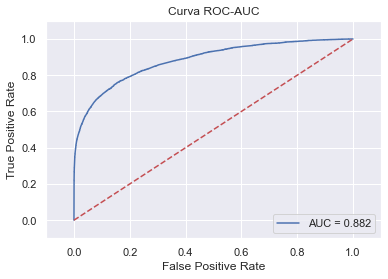

In [34]:
# Plotando a curva ROC-AUC
y_proba = h.predict_proba(X_val)
y_pred = h.predict(X_val)
# take the second column because the classifier outputs scores for
preds = y_proba[:,1]

# fpr means false-positive-rate
# tpr means true-positive-rate
from sklearn.metrics import roc_curve, auc,confusion_matrix,ConfusionMatrixDisplay
# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_val, preds)

auc_score = auc(fpr, tpr)

plt.title('Curva ROC-AUC')
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.3f}')

# it's helpful to add a diagonal to indicate where chance 
# scores lie (i.e. just flipping a coin)
plt.plot([0,1],[0,1],'r--')

plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()

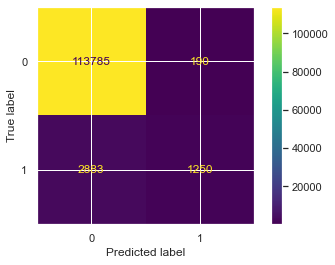

In [35]:
# Plotando a matriz de confusão
# Avaliar a precisão do classificador
confusion_matrix(y_val, y_pred)
cm = confusion_matrix(y_val, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                            display_labels=clf.classes_)
disp.plot()

# Conclusão do projeto

A meta desse projeto é desenvolver um modelo de predição de fraude para um dado conjunto de dados, sendo assim um problema de classificação de fraude. Esse problema em geral apresenta um conjunto de dados desbalanceamento.

O projeto iniciou com um conjunto de 434 variáveis e um conjunto de dados que necessitavam de tratamento especialmente em relação aos dados faltantes (missing).

Optamos por usar uma composição de tecnicas de seleção de variáveis para reduzi o número de variáveis, reduzindo o esforço computacional de treinamento dos modelos e ainda obter uma boa precisão do modelo. A partir das opções restritivas que fizemos no processo de seleção de variáveis chegamos a uma seleção de 60 variáveis, ou seja, uma redução ~86% do número de variáveis.

Posteriormente avaliamos o desempenho dos modelos de Regressão Logística, Random Forest, XGBoost e Isolation Forest em sua configuração padrão. Posteriomente avaliamos o efeito do desbalanceamento dos dados no desempenho dos modelos assim como das metodologias para sanar o problema.

Realizamos a modelagem de uma rede neural MLP para o nosso problema de classificação, porém este modelo foi muito instável em seu desempenho depois de diversas tentativas e devido ao seu custo computacional, não realizamos otimização dos hiperparâmetros.

O modelo que apresentou o melhor desempenho para o conjunto de dados de treino proposto foi o XGBoost com resultado inicial de AUC de 0,613, com a base de dados reamostradas com o RandomUnderSampler foi para 0,777 e finalmente com a otimização dos hiperparâmetros foi para 0,855.

Apesar de ter evoluido bem o desempenho do modelo XGBoost não vai ser capaz de distuingir fraudes dos não fraudes com um bom desempenho conseguindo apenas distinguir com boa precisão as transações que não são fraudes.

Devido ao fato de termos sidos mais restritivos na seleção de variáveis isso pode ter restringido de forma geral o desempenho de todos os modelos e especial para o XGBoost. Isso pois o modelo XGBoost foi o modelo vencedor desse desafio e os campeões do desafio utilizaram 216 variáveis para treinar o modelo. Essa escolha foi feita devido as limitações de tempo e de recurso computacional para poder treinar os modelos e otimizar os hiperparâmetros.

# fim